<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.876 · Análisis de grafos y redes sociales</p>
<p style="margin: 0; text-align:right;">Máster universitario de Ciencia de Datos (<i>Data Science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

# Difusión y propagación de información

## Introducción

Este notebook explora los algoritmos de propagación de la información. 

En primer lugar, se presenta el modelo de cascadas independientes, implementando una de las versiones más extendidas de este. Usando como base la implementación realizada, se analiza cómo afectan los diferentes parámetros de la red a la propagación y cómo podemos maximizar esta propagación mediante la selección de los nodos activos inicialmente.

En segundo lugar, se implementan los modelos de dependencia global Susceptible-Infectado (SI), Susceptible-Infectado-Susceptible (SIS) y Susceptible-Infectado-Recuperado (SIR), observando también cómo afectan los parámetros de los modelos al resultado de la propagación.

Recordad que podéis ir ejecutando los ejemplos que se incluyen en los notebooks para reproducirlos y obtener sus resultados. Además, os animamos a que modifiquéis el código de los ejemplos y ejecutéis vuestras modificaciones, para ir explorando todo el potencial de las librerías que se presentan en los notebooks y los algoritmos que se detallan.

## 1. Modelos de dependencia local: el modelo de cascadas independientes

### 1.1 Modelo de cascadas independientes (ICM)

En los modelos de difusión de información basados en dependencia local, el efecto de cada nodo en la propagación de la información afecta únicamente a sus vecinos inmediatos. Uno de los ejemplos de este tipo de modelos es el modelo de cascadas independientes (ICM). Vamos a implementar la versión básica de este modelo y a explorar cómo se comporta.

Para ello, utilizaremos la clase para representar grafos dirigidos de networkx, [`Digraph`](https://networkx.github.io/documentation/stable/reference/classes/digraph.html). Definiremos un atributo para los nodos del grafo, `active`, que contendrá un valor booleano indicando si el nodo está activo (`active=True`) o inactivo (`active=False`). A su vez, los arcos del grafo tendrán un atributo `prob` que nos indicará la probabilidad de que el nodo de origen active el nodo de destino. 

Empezaremos importando las librerías necesarias y creando tres funciones auxiliares que nos servirán para visualizar la ejecución del algoritmo: 

In [2]:
# Importamos las librerías
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [3]:
# Definimos las constantes DEBUG, INFO y ERR
DEBUG, INFO, ERR = 0, 1, 2

def print_log(msg, msg_log_level=2, current_log_level=2):
    """
    Muestra un mensaje si el nivel de log actual no es mayor que el nivel de log del mensaje.
    """
    if current_log_level <= msg_log_level:
        print(msg)
        
        
def perc_of_active_nodes(g):
    """
    Retorna el porcentaje de nodos activos dado un grafo g.
    """
    return sum(nx.get_node_attributes(g, "active").values()) / len(g.nodes) * 100


def draw_icm(g):
    """
    Muestra una visualización de la red, con los nodos inactivos de color naranja y
    los nodos activos en rojo.
    """
    # calculamos las posiciones 
    pos = nx.kamada_kawai_layout(g)
    # mostramos las aristas
    nx.draw_networkx_edges(g, pos=pos)
    # mostramos todos los nodos en color naranja
    nx.draw_networkx_nodes(g, pos=pos, node_color='#ff6600')
    # repintamos los nodos a destacar en color rojo
    act = [n[0] for n in g.nodes(data=True) if n[1]["active"]]
    nx.draw_networkx_nodes(g, pos=pos, nodelist=act, node_color='#cc0000')
    # mostramos las etiquetas
    nx.draw_networkx_labels(g, pos=pos)
    

Por lo que respecta al algoritmo de cascadas independientes, implementaremos tres funciones, `init_activation`, `init_affect_probs` y `icm`. La función `init_activation` seleccionará los nodos que se encuentran activos al iniciar el algoritmo, según la probabilidad de que un nodo esté activo en el momento inicial t=0. La función `init_affect_probs` inicializará las probabilidades de que un nodo afecte a otro nodo. Para simplificar la implementación, estas probabilidades serán constantes, aunque podríamos fijar otra distribución. Por último, la función `icm` implementará el algoritmo de cascadas independientes: a cada iteración, se seleccionarán aleatoriamente los nodos que se activan, sobre la base de los que se hayan activado en la iteración anterior y de las probabilidades descritas en los arcos.

In [4]:
def init_activation(g, prob=0.1):
    """
    Selecciona los nodos que se encuentran activos en t=0, aleatoriamente. Cada nodo
        estará activo con probabilidad prob.
    """
    act = {n: np.random.choice([True, False], p=[prob, 1-prob]) for n in g.nodes()}
    nx.set_node_attributes(g, act, "active")
    return g

def init_affect_probs(g, prob=0.3):
    """
    Asigna las probabilidades de que un nodo de origen afecte a un nodo de destino. En este caso
        las probabilidades son constantes para todos los arcos del grafo.
    """
    nx.set_edge_attributes(g, {e: prob for e in g.edges()}, 'prob')
    return g

def icm(g):
    """
    Implementa el algoritmo icm.
    """
    # recuperamos los nodos activos en t=0
    activated_last_it = [n[0] for n in g.nodes(data=True) if n[1]["active"]]
    # recuperamos las probabilidades de que un nodo de origen afecte a un nodo de destino
    edge_probs = nx.get_edge_attributes(g, 'prob')
    
    evolution = []
    t = 1
    while len(activated_last_it) != 0:
        evolution.append(g.copy())
        print_log("[t={}] Activated in previous iteration: {}".format(t, activated_last_it), INFO, CURRENT_LOG_LEVEL)
        print_log("[t={}] Percentage of active nodes: {}%".format(t, perc_of_active_nodes(g)), INFO, CURRENT_LOG_LEVEL)
        activated_this_it = []
        # para cada nodo activado en la iteración anterior, decidimos si se activan sus succesores:
        for node in activated_last_it:
            for neigh in g.successors(node):
                print_log("\tDealing with source {} destination {}".format(node, neigh), DEBUG, CURRENT_LOG_LEVEL)
                # solo se puede activar un nodo que actualmente esté inactivo
                if not g.nodes(data=True)[neigh]["active"]:
                    # se decide aleatoriamente si se activa el vecino en función de la probabilidad del arco
                    prob = edge_probs[(node, neigh)]
                    activate_now = np.random.choice([True, False], p=[prob, 1-prob])
                    if activate_now:
                        print_log("\t\t{} is not active and will activate".format(neigh), DEBUG, CURRENT_LOG_LEVEL)
                        activated_this_it.append(neigh)
                        nx.set_node_attributes(g, {neigh: True}, "active")
        activated_last_it = activated_this_it
        t += 1
    
    # devolvemos una lista con la evolución del algoritmo a cada iteración
    return evolution

Vamos pues a ejecutar el algoritmo icm para un grafo generado aleatoriamente:

In [5]:
# Seleccionamos el máximo nivel de log
CURRENT_LOG_LEVEL = DEBUG
# Fijamos la semilla de aleatoriedad
np.random.seed(1)

# Generamos un grafo dirigido aleatorio con 10 nodos
g = nx.erdos_renyi_graph(n=10, p=0.5, seed=1, directed=True)
# Seleccionamos los nodos activos inicialmente (cada nodo se activará en t=0 con probabilidad 0.1)
g = init_activation(g, prob=0.1)
# Fijamos la probabilidad de activar un vecino a 0.3 
g = init_affect_probs(g, prob=0.3)

# Sjecutamos el algoritmo
evolution = icm(g)

[t=1] Activated in previous iteration: [2, 5]
[t=1] Percentage of active nodes: 20.0%
	Dealing with source 2 destination 1
	Dealing with source 2 destination 3
	Dealing with source 2 destination 6
		6 is not active and will activate
	Dealing with source 2 destination 7
	Dealing with source 2 destination 8
		8 is not active and will activate
	Dealing with source 2 destination 9
	Dealing with source 5 destination 2
	Dealing with source 5 destination 6
[t=2] Activated in previous iteration: [6, 8]
[t=2] Percentage of active nodes: 40.0%
	Dealing with source 6 destination 2
	Dealing with source 6 destination 3
	Dealing with source 6 destination 5
	Dealing with source 6 destination 7
	Dealing with source 8 destination 0
		0 is not active and will activate
	Dealing with source 8 destination 4
		4 is not active and will activate
	Dealing with source 8 destination 5
[t=3] Activated in previous iteration: [0, 4]
[t=3] Percentage of active nodes: 60.0%
	Dealing with source 0 destination 1
	Deali

Inicialmente (en t=0) los nodos 2 y 5 están activos. En t=1, de entre los sucesores del nodo 2 (que son los nodos 1, 3, 6, 7, 8 y 9), se activan los nodos 6 y 8. Los sucesores del nodo 5 (que son el 2 y 6) ya están activos. En t=2 se decide qué sucesores de los nodos 6 y 8 se activan (se activan el 0 y el 4). Finalmente, en t=3 se decide qué sucesores de los nodos 0 y 4 se activan. Dado que ninguno de ellos lo hace, la ejecución del algoritmo termina, con el 60% de los nodos activados.

Podemos utilizar la función `draw_icm` para visualizar gráficamente la ejecución del algoritmo:

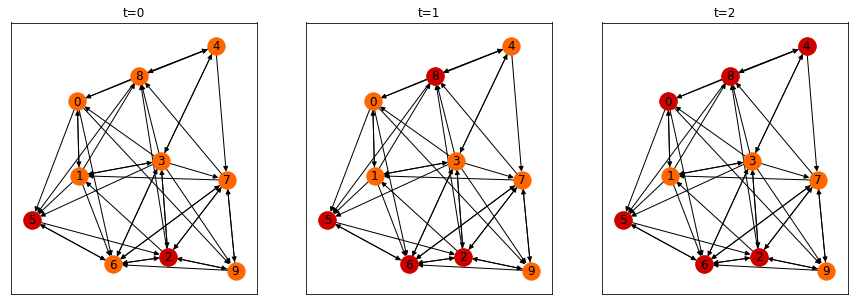

In [6]:
# Generamos una figura con 3 subfiguras (columnas) y tantas filas como sea necesario
num_rows = ceil(len(evolution)/3)
plt.figure(num=None, figsize=(15, 5*num_rows))
for i, e in enumerate(evolution):
    ax = plt.subplot(num_rows, 3, i+1)
    ax.set_title("t={}".format(i))
    draw_icm(e)

### 1.2 Efectos de los parámetros de red sobre el número de nodos activados

Es interesante notar que la ejecución anterior del algoritmo ha finalizado con solo un 60% de los nodos activos. Dado que el algoritmo es probabilístico, podríamos preguntarnos si este resultado es habitual para una red de las características que hemos utilizado. Para analizarlo, generaremos varias redes similares (usando el mismo modelo, con el mismo número de nodos y de arcos) y ejecutaremos el algoritmo con los mismos parámetros (la misma probabilidad de activación de un nodo en el estado inicial y de que un nodo active a uno de sus sucesores):

In [7]:
# Bajamos el nivel de log para visualizar únicamente los mensajes de error
CURRENT_LOG_LEVEL = ERR

# Creamos una función que recibe como parámetros la configuración de red y las probabilidades a usar en icm
def ending_active(num_nodes=10, er_prob=0.5, init_activ_prob=0.1, init_affect_prob=0.3, num_its=300):
    perc_activated = []
    for _ in range(num_its):
        g = nx.erdos_renyi_graph(n=num_nodes, p=er_prob, directed=True)
        g = init_activation(g, prob=init_activ_prob)
        g = init_affect_probs(g, prob=init_affect_prob)
        evolution = icm(g)
        # guardamos el porcentaje de nodos activos al finalizar la ejecución
        if len(evolution):
            perc_activated.append(perc_of_active_nodes(evolution[-1]))
        else:
            perc_activated.append(0)
    return np.mean(perc_activated)

In [8]:
# Calculamos la media del porcentaje de nodos activos al final de la ejecución del algoritmo
ending_active()

34.56666666666667

Así pues, la media de los nodos activos al final de la ejecución es bastante inferior al valor que hemos obtenido en la primera ejecución del algoritmo. 

Por otro lado, podemos usar la función `ending_active` que hemos definido para observar cómo afectan los parámetros de red al resultado de la ejecución del algoritmo. Por ejemplo, podemos ver cómo evoluciona el porcentaje de nodos activos al final de la ejecución al variar la densidad de la red:

<u>Nota</u>: la ejecución del siguiente bloque de código puede tardar unos minutos. Si queréis reducir el tiempo de ejecución, podéis rebajar la resolución de la gráfica, disminuyendo el tercer parámetro de la llamada a `arange`.

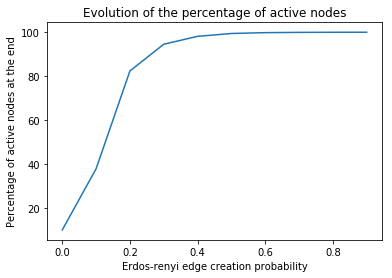

In [9]:
# Variamos la probabilidad de conexión de una arista del modelo erdos-renyi de 0 a 1, con paso 0.01
xs = np.arange(0, 1, 0.1)
# Calculamos el número medio de nodos activados al final de la ejecución para cada valor de x
ys = [ending_active(num_nodes=100, er_prob=x, init_affect_prob=0.1) for x in xs]

# Mostramos una gráfica con el resultado
plt.figure()
plt.plot(xs, ys)
plt.title("Evolution of the percentage of active nodes")
plt.xlabel("Erdos-renyi edge creation probability")
_ = plt.ylabel("Percentage of active nodes at the end")

Podéis probar también a cambiar otros parámetros de la ejecución del algoritmo, para ver cómo afectan al porcentaje final de nodos activos:

In [10]:
ending_active(num_nodes=100, er_prob=0.2, init_activ_prob=0.1, init_affect_prob=0.5, num_its=300)

99.99

### 1.3 Maximización de la propagación

En el apartado anterior hemos visto como varia el conjunto de nodos activos al final de la ejecución al modificar la topología de la red de conexiones. De todos modos, en muchos de los problemas reales en los que podríamos aplicar estos modelos, las redes ya existen (ya están creadas) y es difícil modificarlas para conseguir nuestros propósitos. En cambio, a veces podremos influir en cuáles son los nodos activos al principio de la ejecución. En este contexto, tiene sentido plantearse qué nodos queremos activar al principio, para intentar maximizar el conjunto de nodos activos al finalizar la ejecución. Esto tendría sentido, por ejemplo, en el contexto de una campaña publicitaria, en la que podríamos promocionar un producto (quizás incluso regalar muestras de este) a un conjunto pequeño de usuarios, con el objetivo de que hablen bien de él, intentando maximizar el número de usuarios que acaban oyendo hablar del producto anunciado.

Vamos a implementar la estrategia *greedy* de maximización de la propagación del algoritmo de cascadas independientes. Para ello, implementaremos dos funciones: la función `evaluate_candidate` permitirá evaluar la contribución a la propagación de un nodo concreto dado el estado actual de la red; la función `greedy_max` seleccionará los *k* nodos que deberán activarse inicialmente, seleccionando el mejor candidato en cada momento (según los resultados de `evaluate_candidate`).

In [11]:
def evaluate_candidate(g, candidate, num_its=20):
    """
    Retorna la media de nodos activados por el nodo `candidate` en `num_its` iteraciones.
    """
    edge_probs = nx.get_edge_attributes(g, 'prob')
    num_nodes_activated = []
    for _ in range(num_its):
        activated_this_it = 0
        # para cada sucesor del candidato, probamos si se activa considerando las probabilidades de los arcos
        for neigh in g.successors(candidate):
            if not g.nodes(data=True)[neigh]["active"]:
                prob = edge_probs[(candidate, neigh)]
                activate_now = np.random.choice([True, False], p=[prob, 1-prob])
                if activate_now:
                    activated_this_it += 1
        # guardamos el número de nodos que activa el candidato cada vez que repetimos la prueba
        num_nodes_activated.append(activated_this_it)
    # devolvemos la media del número de nodos activados
    return np.mean(num_nodes_activated)


def greedy_max(g, k):
    """
    Selecciona los `k` nodos que maximizan la propagación siguiendo una estrategia greedy.
    """
    initial_activation = []
    # a cada iteración del bucle, se selecciona el mejor candidato dado el estado actual de la red
    for _ in range(k):
        # todos los nodos inactivos son candidatos a activarse
        candidates = [n[0] for n in g.nodes(data=True) if not n[1]["active"]]
        best_candidate, best_num_activations = -1, 0
        for candidate in candidates:
            # guardamos el mejor candidato, según el resultado de `evaluate_candidate`
            num_activations = evaluate_candidate(g, candidate)
            if num_activations >= best_num_activations:
                best_candidate = candidate
                best_num_activations = num_activations
        nx.set_node_attributes(g, {best_candidate: True}, "active")
        initial_activation.append(best_candidate)
        
    return g, initial_activation        

Para probar el algoritmo, generaremos una red con 50 nodos, seleccionaremos 3 nodos iniciales usando, por un lado, la estrategia *greedy* que acabamos de implementar y, por otro lado, realizando una selección aleatoria, y visualizaremos el grafo resultante de aplicar el algoritmo `icm` con ambas inicializaciones:

Greedy selects as initial active nodes: [21, 34, 31]
Random selects as initial active nodes: [6, 29, 4]


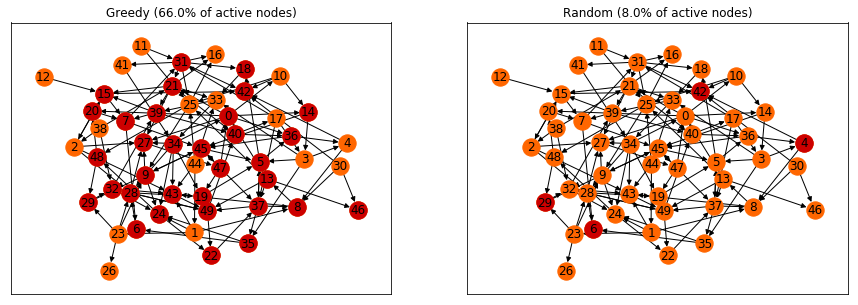

In [12]:
# Seleccionamos el nivel de log ERR
CURRENT_LOG_LEVEL = ERR
np.random.seed(1)

# Fíjamos a 3 el número de nodos activos al inicio
num_k = 3

# Generamos un grafo dirigido aleatorio con 50 nodos
g = nx.erdos_renyi_graph(n=50, p=0.05, seed=1, directed=True)
# Fijamos la probabilidad de activar un vecino a 0.3 
g = init_affect_probs(g, prob=0.5)
# Inicializamos los atributos `active` de los nodos (fijándolos todos a False)
g = init_activation(g, prob=0)

# Seleccionamos los nodos iniciales con el algoritmo de maximización de la propagación
g_greedy, initial_activation_gr = greedy_max(g.copy(), k=num_k)
# Seleccionamos los nodos iniciales aleatoriamente
g_random, initial_activation_rand = g.copy(), list(np.random.choice(g.nodes(), num_k))
nx.set_node_attributes(g_random, {n: True for n in initial_activation_rand}, "active")

# Ejecutamos el algoritmo icm con las dos inicializaciones
evolution_greedy = icm(g_greedy)
evolution_random = icm(g_random)

# Visualizamos el resultado
plt.figure(num=None, figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
print("Greedy selects as initial active nodes: {}".format(initial_activation_gr))
ax.set_title("Greedy ({}% of active nodes)".format(perc_of_active_nodes(evolution_greedy[-1])))
draw_icm(evolution_greedy[-1])
           
ax = plt.subplot(1, 2, 2)
print("Random selects as initial active nodes: {}".format(initial_activation_rand))
ax.set_title("Random ({}% of active nodes)".format(perc_of_active_nodes(evolution_random[-1])))
draw_icm(evolution_random[-1])

En este caso, el algoritmo *greedy* consigue mejorar la propagación de la información frente a una selección aleatoria. De todos modos, si probáis a variar la semilla de aleatoriedad (por ejemplo, comentando la línea `np.random.seed(1)`), veréis que esto no siempre es así: las características del grafo junto al hecho de que el algoritmo *greedy* seleccione el mejor candidato a cada momento sin tener en cuenta las consecuencias a largo plazo de esta selección, hacen que el resultado no sea siempre óptimo.

## 2. Modelos de dependencia global

A diferencia de los modelos de dependencia local, en los modelos de dependencia global la decisión de activación (o infección) de un individuo no depende de sus vecinos directos en la red. Vamos a implementar los tres modelos de propagación de epidemias que se describen en el capítulo 7 del libro *Análisis de datos de redes sociales*, para observar cómo se comportan según los parámetros que se consideran. En estos modelos, las conexiones concretas de la red serán desconocidas, pero sabremos cuál es el grado medio de los nodos, *k*.

### 2.1 Modelo Susceptible-Infectado (SI)

En el modelo susceptible-infectado, los individuos solo pueden estar en dos estados (susceptible o infectado) y, una vez infectados, ya no pueden volver a cambiar de estado. El parámetro $\beta$ determina la probabilidad de infección cuando hay contacto entre individuos.

In [13]:
from math import e, pow

def model_si(i_0, beta, k, t):
    """
    Calculamos la fracción de individuos infectados en el instante t según el modelo SI.
    """
    return i_0*pow(e, beta*k*t)/(1+i_0*(pow(e, beta*k*t)-1))

Vamos a utilizar la función `model_si` que acabamos de definir para ver cómo evolucionan la fracción de individuos infectados y susceptibles en el tiempo, para una red con grado medio 4, empezando con un 1% de los nodos infectados y con $\beta=0.03$.

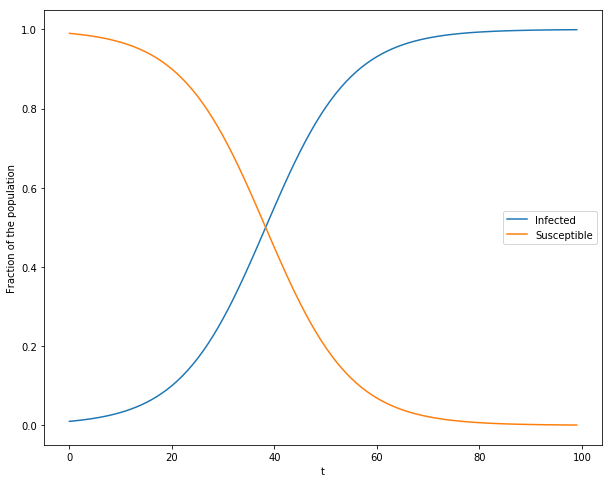

In [14]:
# Calculamos la fracción de individuos infectados para t en [0, 100)
i_0, k, beta = 1/100, 4, 0.03
ts = np.arange(0, 100, 1)
it = [model_si(i_0, beta, k, t) for t in ts]

# Mostramos gráficamente el resultado
plt.figure(num=None, figsize=(10, 8))
plt.plot(ts, it)
plt.plot(ts, [1-i for i in it])
plt.legend(["Infected", "Susceptible"])
plt.xlabel("t")
_ = plt.ylabel("Fraction of the population")

Podemos observar que, debido a que los individuos no pueden recuperarse, a medida que pasa el tiempo cada vez hay más individuos infectados, hasta que los está toda la población.

También podemos utilizar la función `model_si` para ver como se comporta el modelo para distintos valores de *k* (el grado medio de la red):

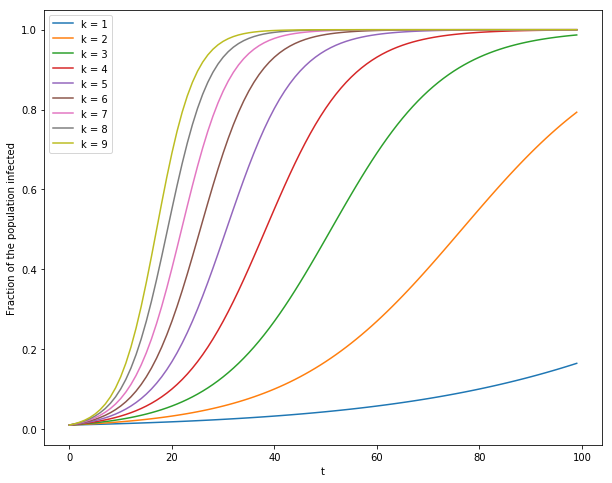

In [15]:
plt.figure(num=None, figsize=(10, 8))

# Calculamos la fracción de infectados en el tiempo para distintos valores de k
i_0, beta = 1/100, 0.03
ts, ks, l = range(0, 100), range(1, 10), []
for k in ks:
    it = [model_si(i_0, beta, k, t) for t in ts]
    plt.plot(ts, it)
    l.append("k = {}".format(k))
    
plt.legend(l)
plt.xlabel("t")
_= plt.ylabel("Fraction of the population infected")

Así pues, al aumentar el grado medio de la red, se favorece la infección (ya que los individuos tienen más contactos). Por ejemplo, en *t=20*, solo un 1.8% de los individuos están infectados para *k=1*, mientras que el porcentaje asciende hasta el 69.1% para *k=9*.

### 2.2 Modelo Susceptible-Infectado-Susceptible (SIS)

En el modelo Susceptible-Infectado-Susceptible, los individuos también pueden estar únicamente en dos estados, susceptible o infectado, pero ahora pueden volver al estado susceptible después de haber estado infectados. 

In [16]:
def model_sis(i_0, beta, mu, k, t):
    """
    Calculamos la fracción de individuos infectados en el instante t según el modelo SIS.
    """    
    c = i_0/(1-i_0-mu/(beta*k))
    return (1-mu/(beta*k))*c*pow(e, (beta*k-mu)*t)/(1+c*(pow(e, (beta*k-mu)*t)))

Vamos a utilizar la función `model_sis` que acabamos de definir para ver cómo evolucionan la fracción de individuos infectados, para una red con grado medio 4, empezando con un 1% de los nodos infectados, con una probabilidad de infección $\beta=0.05$, y variando la probabilidad de recuperación $\mu$:

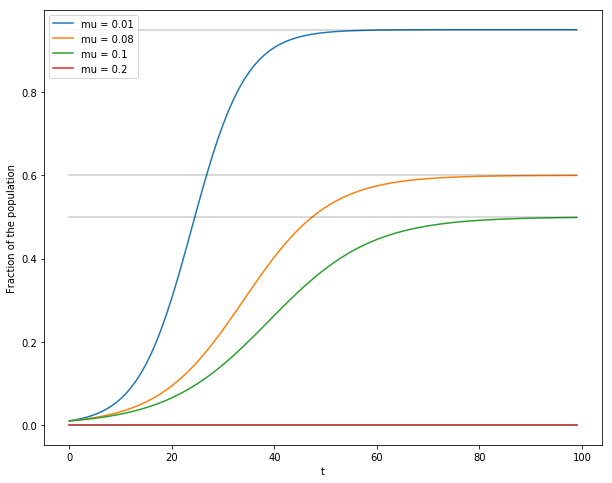

In [17]:
# Calculamos la fracción de infectados en el tiempo para distintos valores de mu
mus = [0.01, 0.08, 0.1, 0.2]
i_0, k, beta = 1/100, 4, 0.05
plt.figure(num=None, figsize=(10, 8))
ts = np.arange(0, 100, 1)
l, i_infs = [], []
for mu in mus:
    # calculamos la fracción de individuos infectados en función de t
    it = [model_sis(i_0, beta, mu, k, t) for t in ts]
    # calculamos la fracción de individuos infectados cuando t tiende a infinito
    i_inf = 1 - mu/(beta*k)
    plt.plot(ts, it)
    i_infs.append(i_inf)
    l.append("mu = {}".format(mu))
    
plt.legend(l)
plt.xlabel("t")
_ = plt.ylabel("Fraction of the population")

# Mostramos el valor de la fracción de infectados cuando t tiende a infinito como una
# línea gris
for i_inf in i_infs:
    plt.plot(ts, [i_inf for _ in ts], alpha=0.2, color='k')

Podemos ver que, para una misma probabilidad de infección $\beta=0.05$, cuanto mayor sea la probabilidad de recuperación $\mu$ menos individuos estarán infectados a cada instante de tiempo (y más lento será el crecimiento de la fracción de infectados).

### 2.3 Modelo Susceptible-Infectado-Recuperado (SIR)

Por último, implementaremos el modelo Susceptible-Infectado-Recuperado, en el que los individuos pueden estar, además de en estado susceptible e infectado, en estado recuperado. Un individuo recuperado ya no puede volver a infectarse:

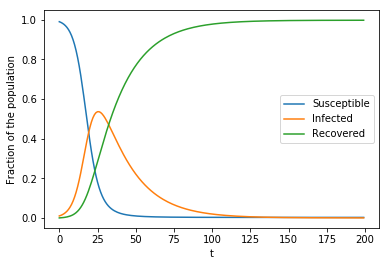

In [18]:
from scipy.integrate import odeint

# Fijamos la fracción inicial de infectados a 0.01 (1%) y la de recuperados a 0 (el resto son susceptibles)
i_0, r_0 = 1/100, 0
s_0 = 1 - i_0 - r_0
# Dijamos la probabilidad de infección y de recuperación
beta, mu = 0.3, 0.05
# Evaluaremos la función en el intervalo t = [0, 200)
t = range(0, 200)

# Definimos las ecuaciones diferenciales
def deriv(y, t, beta, mu):
    s, i, r = y
    dsdt = - beta*s*i 
    didt = beta*s*i - mu*i
    drdt = mu*i
    return dsdt, didt, drdt

# Definirmos los parámetros iniciales
y0 = s_0, i_0, r_0
# Definimos la función `model_sir`, que calcula la fracción de susceptibles, infectados y recuperados en 
# función del tiempo
model_sir = lambda t: odeint(deriv, y0, t, args=(beta, mu)).T
# Calculamos la fracción de susceptibles, infectados y recuperados para t = [0, 200)
s, i, r = model_sir(t)

# Mostramos el resultado
fig = plt.figure()
plt.plot(t, s, t, i, t, r)
plt.xlabel("t")
plt.ylabel("Fraction of the population")
_ = plt.legend(["Susceptible", "Infected", "Recovered"])

Variando los parámetros $\beta$ y $\mu$, podemos ver qué efectos tienen las probabilidades de infección y recuperación sobre el resultado final de la población.